# Fernando Leon Franco

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from colorstreak import Logger
import re

In [2]:
def print_bar(i, cantidad_registros, contexto="PROGRESO"):
    porcentaje = (i + 1) / cantidad_registros * 100
    # Con emojis
    barra = int(50 * (i + 1) / cantidad_registros) * "🟩"
    espacio = int(50 - len(barra)) * "⬛️"

    print(f"\r{contexto}: |{barra}{espacio}| {porcentaje:6.2f}%", end="", flush=True)

In [3]:
def get_texts_from_file(path_corpus, path_truth):

    tr_txt = [] # Aqui van los twits
    tr_y = [] # Aqui van las etiquetas

    with open(path_corpus, 'r', encoding='utf-8') as f_corpus, open(path_truth , 'r', encoding='utf-8') as f_truth:
        
        for twitt in f_corpus:
            tr_txt += [twitt]
            
        for label in f_truth:
            tr_y += [label]
    
    return tr_txt,tr_y        

In [4]:
path_global = "data/mex"
path_corpus = path_global + '/mex20_train.txt'
path_truth = path_global + '/mex20_train_labels.txt'


tr_txt, tr_y = get_texts_from_file(path_corpus,path_truth)



# Construir los datos de validación
path_corpus = path_global + '/mex20_val.txt'
path_truth = path_global + '/mex20_val_labels.txt'


va_txt, va_y = get_texts_from_file(path_corpus,path_truth)


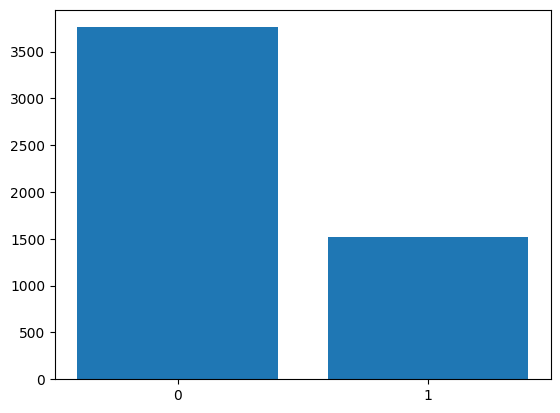

0: 3759
1: 1519


In [5]:
# Ver los datos saber si es balanceado o desbalanceado
count_0 = 0
count_1 = 0

for label in tr_y:
    label = label.strip()
    if label == '0':
        count_0 += 1
    elif label == '1':
        count_1 += 1

plt.bar(['0','1'],[count_0,count_1])
plt.show()

print(f"0: {count_0}")
print(f"1: {count_1}")

In [6]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

corpus_de_palabras = []

for doc in tr_txt:
    corpus_de_palabras += tokenizer.tokenize(doc)
    
fdist = nltk.FreqDist(corpus_de_palabras)



In [7]:
"""
VERSION DEL PROFE
"""


def sort_dist(freq_dist):
    aux = [(freq_dist[key], key) for key in freq_dist.keys()]
    aux.sort(reverse=True)
    return aux

vocabulario = sort_dist(fdist)

vocabulario = vocabulario[:5000] # Shape (5000, 2)


# Es redundante pero asegura un orden en diccionario en Python (No importa por que python se indexa)

dict_indices = {}

contador = 0

for peso, palabra in vocabulario:
    dict_indices[palabra] = contador
    contador += 1
    

def built_bow_tr_profe_version(tuits, Vocabulario, dict_indices):
    
    BOW = np.zeros((len(tuits), len(Vocabulario)), dtype=int)

    contador = 0
    for tr in tuits:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr.lower())) # Tuit Tokenizado
        for palabra in fdist_doc:
            if palabra in dict_indices:
                BOW[contador, dict_indices[palabra]] = fdist_doc[palabra] # FRECUENCIA DE LA PALABRA EN VEZ DE HACERLO BINARIO
        contador += 1

    return BOW


In [8]:
bolsa_de_palabras_tr = built_bow_tr_profe_version(tr_txt, vocabulario, dict_indices)
print(bolsa_de_palabras_tr.shape)

(5278, 5000)


In [9]:
bolsa_de_palabras_tr

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], shape=(5278, 5000))

# Compute Document Ocurrence Representation


In [10]:


# count * log(T / Nk)
def calcular_peso(freq, Nk_j, T):
    if freq == 0:
        return 0.0
    return freq * np.log(T / max(1, Nk_j)) 



def compute_dor(bow, vocabulario):
    renglones, columnas = bow.shape
    assert columnas == len(vocabulario), "El vocabulario no coincide con columnas en BOW"
    

    Nk = (bow > 0).sum(axis=0) # Tamaño 
    T = renglones

    dor = np.zeros((renglones, columnas), dtype=float)
    
    for i in range(renglones):
        for j in range(columnas):
            dor[i, j] = calcular_peso(bow[i, j], Nk[j], T)
            
    return dor

In [11]:
dor = compute_dor(bolsa_de_palabras_tr, vocabulario)
print(dor.shape)

(5278, 5000)


In [12]:
dor

array([[0.        , 1.61486246, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.80743123, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.80743123, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.84894225, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.92447113, 0.80743123, 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(5278, 5000))

In [13]:
def compute_dor_profe(TR):
    DTR = np.zeros((TR.shape[1], TR.shape[0]), dtype=float)

    tam_v = TR.shape[1] # Tamaño del vocabulario TOTAL
    
    for i,doc in enumerate(TR):
        non_zero_positions = np.nonzero(doc)[0] # Esto me dice las dimensiones que no son cero
        tamaño_vocabulario = len(non_zero_positions)
        for termino in non_zero_positions:
            DTR[termino, i] = doc[termino] * np.log(tam_v / tamaño_vocabulario)
    return DTR

In [14]:
DRT = compute_dor_profe(bolsa_de_palabras_tr)



# Normalización

In [15]:

DOR_normalizado = preprocessing.normalize(DRT, norm='l2')

print(DOR_normalizado.shape)

(5000, 5278)


In [16]:
from sklearn.feature_selection import SelectKBest, chi2

feature_selector = SelectKBest(chi2, k=1000)

# Aprende a como hacer selección de las palabras de manera muy interesante en automatico les da la relevancia
feature_selector.fit(bolsa_de_palabras_tr, tr_y)



,score_func,<function chi2 at 0x11d1e1da0>
,k,1000


In [17]:
best = feature_selector.get_support(indices=True)

In [18]:
best

array([   0,    1,    2,    4,    5,    6,    7,   10,   11,   12,   13,
         17,   18,   19,   20,   22,   24,   25,   28,   30,   32,   36,
         37,   38,   39,   41,   43,   44,   48,   50,   53,   54,   56,
         57,   58,   59,   61,   63,   64,   65,   66,   67,   69,   70,
         71,   75,   78,   79,   86,   88,   89,   92,   93,   94,   97,
        100,  102,  103,  104,  105,  106,  107,  108,  111,  114,  115,
        116,  117,  119,  120,  122,  123,  124,  128,  129,  131,  133,
        134,  136,  143,  147,  148,  150,  151,  153,  154,  163,  166,
        170,  177,  178,  179,  182,  183,  184,  187,  188,  189,  191,
        196,  198,  200,  209,  211,  217,  221,  222,  225,  230,  231,
        233,  236,  237,  240,  243,  245,  246,  248,  249,  250,  252,
        253,  257,  258,  260,  262,  263,  264,  265,  266,  271,  273,
        279,  281,  284,  285,  289,  291,  294,  295,  298,  299,  301,
        302,  304,  306,  307,  308,  309,  310,  3

In [19]:
dict_indices_invertido = {valor: key for key, valor in dict_indices.items()}
dict_indices_invertido

{0: ',',
 1: 'de',
 2: 'que',
 3: '.',
 4: 'la',
 5: 'a',
 6: 'y',
 7: '!',
 8: 'no',
 9: '@USUARIO',
 10: 'me',
 11: 'el',
 12: 'en',
 13: 'se',
 14: 'es',
 15: 'con',
 16: '?',
 17: 'verga',
 18: 'los',
 19: 'madre',
 20: 'por',
 21: 'las',
 22: '"',
 23: 'un',
 24: 'te',
 25: 'mi',
 26: 'lo',
 27: 'putas',
 28: 'una',
 29: '...',
 30: 'putos',
 31: 'para',
 32: '😂',
 33: 'si',
 34: 'ya',
 35: 'como',
 36: 'su',
 37: 'pero',
 38: 'tu',
 39: 'loca',
 40: 'le',
 41: 'más',
 42: 'No',
 43: 'del',
 44: 'gorda',
 45: 'al',
 46: 'bien',
 47: 'A',
 48: '¿',
 49: 'Y',
 50: 'son',
 51: 'Me',
 52: 'o',
 53: 'feas',
 54: 'cuando',
 55: 'Que',
 56: ':',
 57: 'yo',
 58: 'les',
 59: 'porque',
 60: 'ni',
 61: 'está',
 62: 'ser',
 63: 'estoy',
 64: 'sus',
 65: 'todos',
 66: 'esta',
 67: 'puta',
 68: 'Ya',
 69: 'todo',
 70: 'pinche',
 71: 'puto',
 72: 'tan',
 73: 'Si',
 74: 'La',
 75: 'qué',
 76: '…',
 77: 'eso',
 78: 'muy',
 79: 'soy',
 80: 'hasta',
 81: 'así',
 82: '¡',
 83: '<URL>',
 84: 'mamar',


In [20]:
t_words = [dict_indices_invertido[index] for index in best]

In [21]:
# dict_indices {"palabra": "dimension_en_bow",...}
target_matrix = np.array([DOR_normalizado[dict_indices[word]] for word in t_words])

In [22]:
target_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.02700498,
        0.01383511],
       [0.02718223, 0.        , 0.01543368, ..., 0.01631947, 0.        ,
        0.01478211],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(1000, 5278))

In [23]:
target_matrix.shape

(1000, 5278)

In [24]:
DOR_normalizado.shape

(5000, 5278)

# Reducción de Dimensionalidad

In [25]:
from sklearn.manifold import TSNE


reduce_matrix = TSNE(n_components=2).fit_transform(target_matrix)


In [26]:
reduce_matrix

array([[ 4.7225637,  2.3089724],
       [ 3.8765097,  3.1050482],
       [ 3.934125 ,  1.8475806],
       ...,
       [-1.9082683, 36.422634 ],
       [-6.596594 , 17.623215 ],
       [ 5.488107 , 10.600108 ]], shape=(1000, 2), dtype=float32)

In [27]:
max_x , max_y = np.max(reduce_matrix, axis=0)
min_x , min_y = np.min(reduce_matrix, axis=0)


print(f"max_x: {max_x}, max_y: {max_y}")
print(f"min_x: {min_x}, min_y: {min_y}")

max_x: 50.43037033081055, max_y: 48.87617492675781
min_x: -49.2150764465332, min_y: -46.12471389770508


/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ferleon/Github/semestre_v/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWa

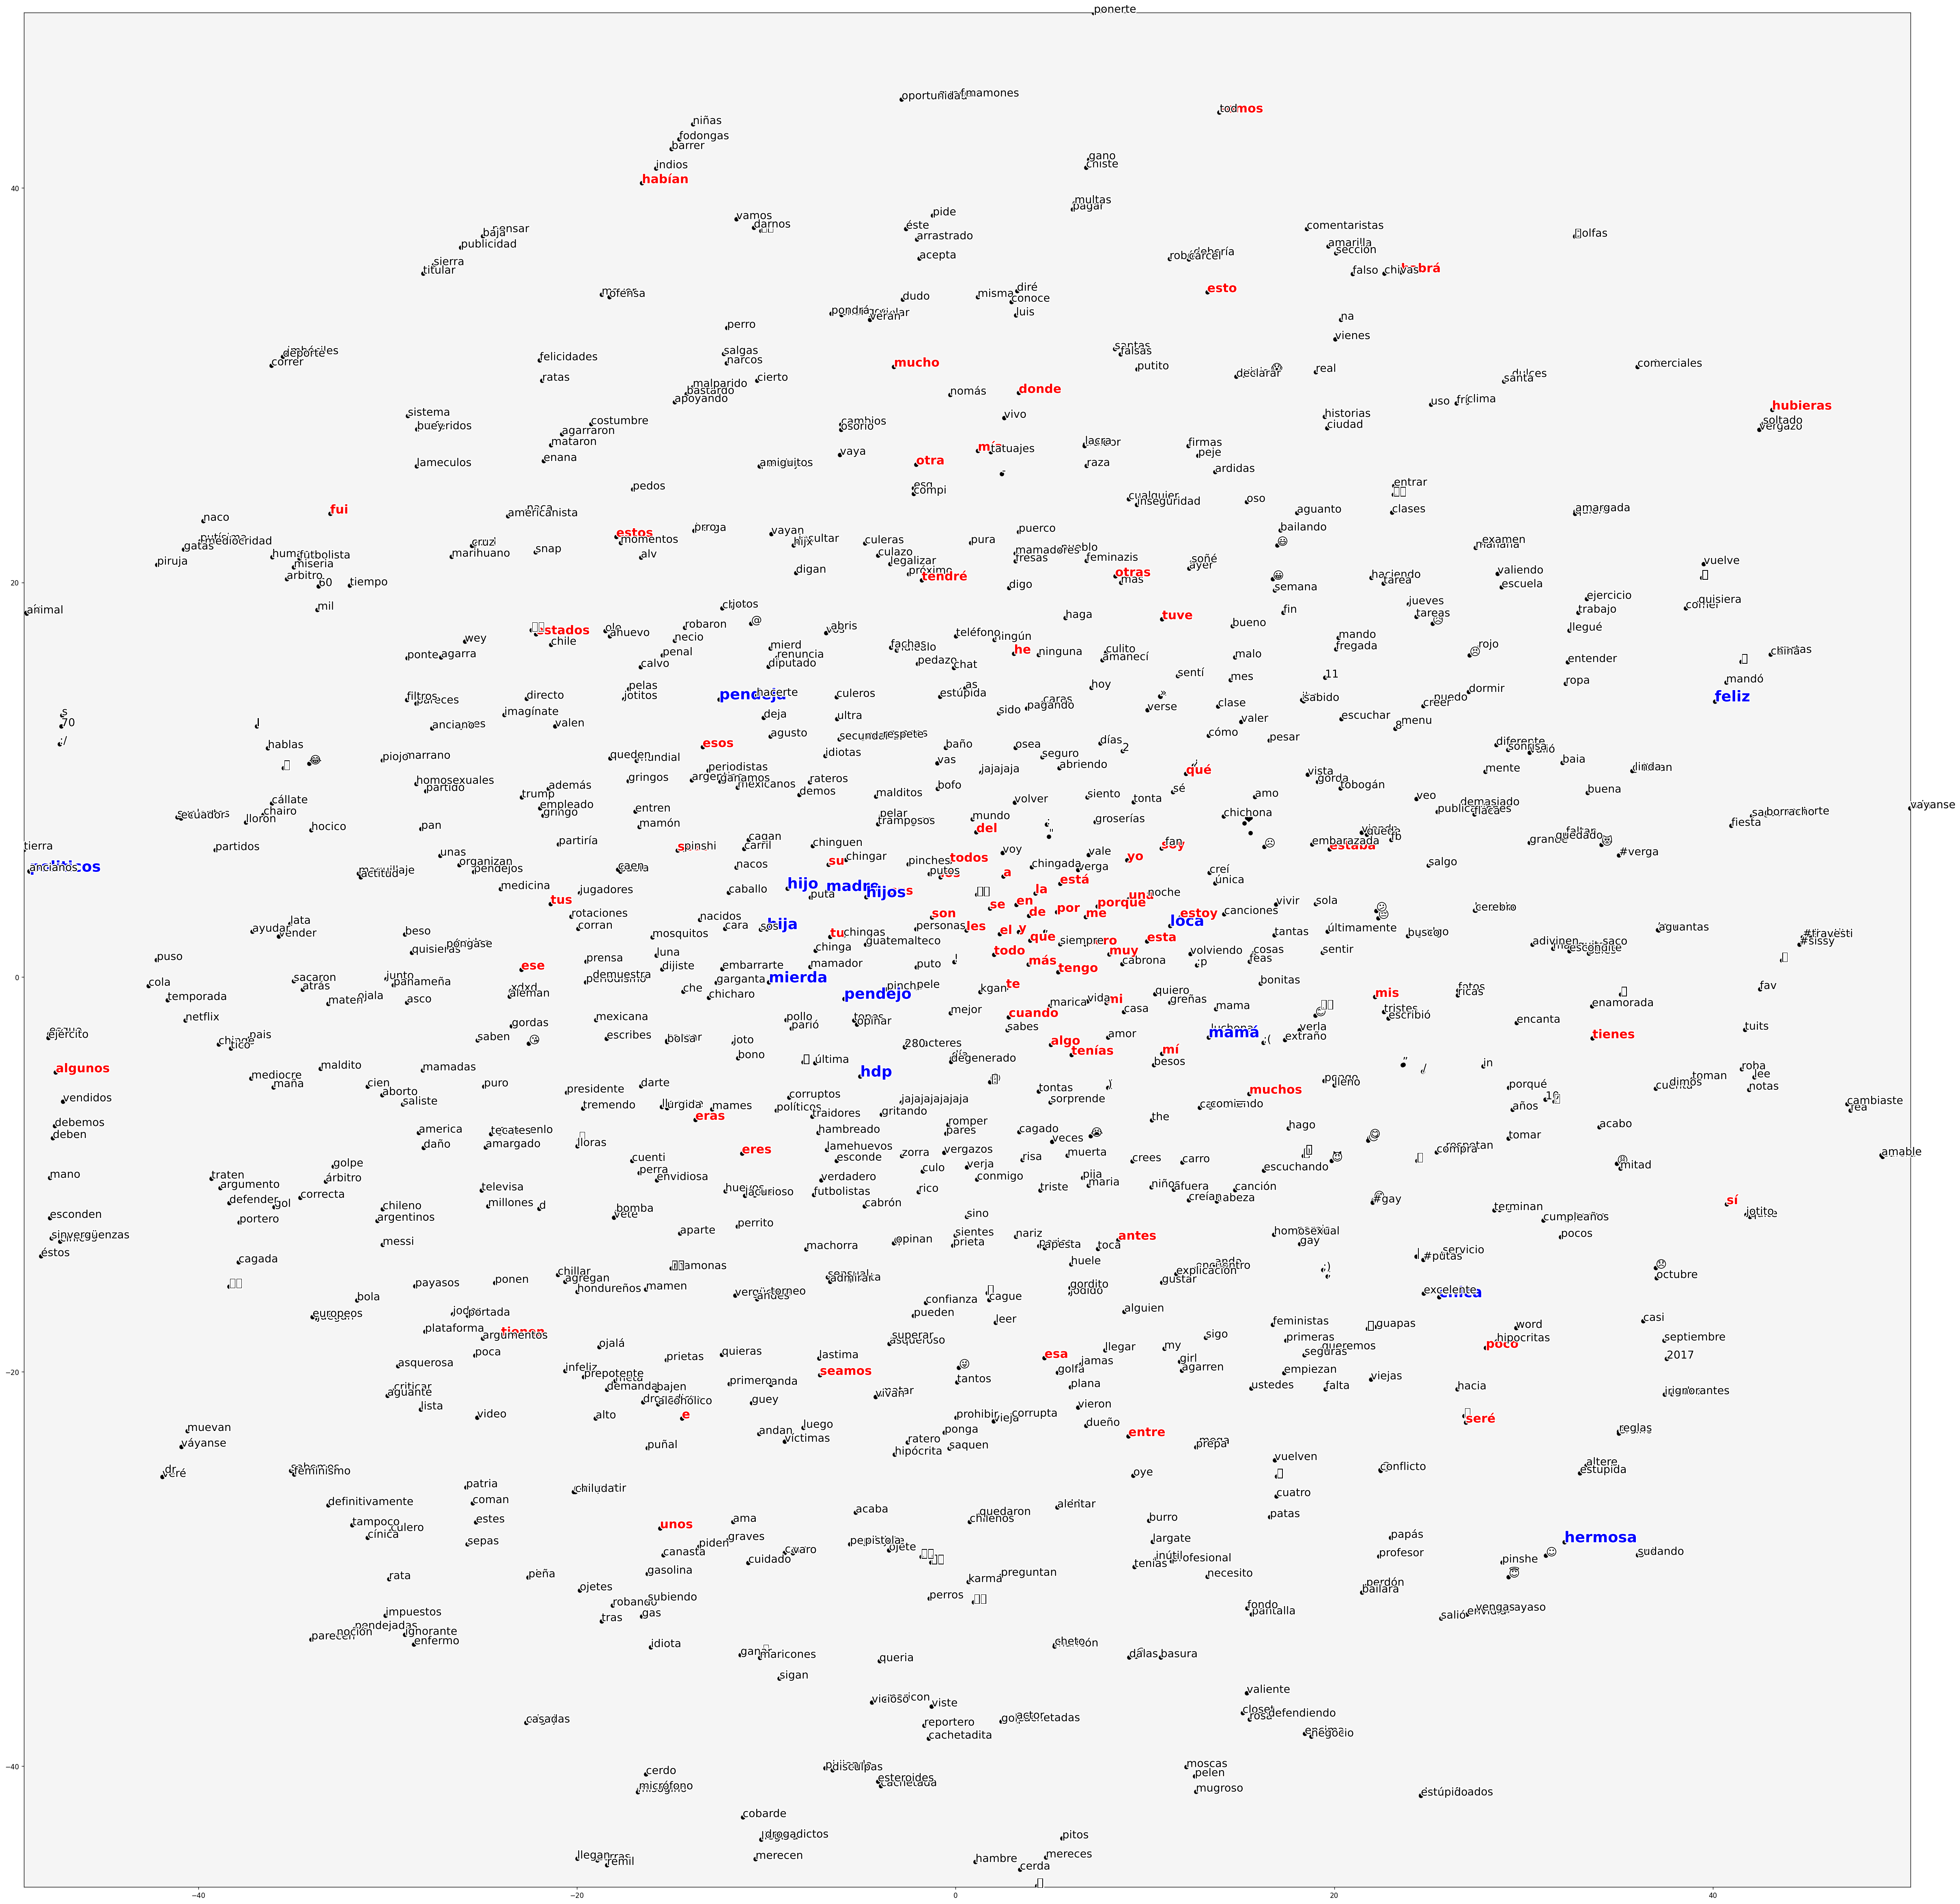

In [28]:
from matplotlib import patheffects

x, y = reduce_matrix[:, 0], reduce_matrix[:, 1]

plt.figure(figsize=(50, 50), dpi=120)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.scatter(x, y, s=30, color='black')






stop_words = stopwords.words('spanish')


for i, word in enumerate(t_words):
    if word in stop_words:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=18, 
            color='red', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    elif word in ['politicos', 'corrupción', 'PRI', 'feliz', 
              'hermosa', 'chica', 'tu', 'hdp','madre','madres',
              '@usuario' ,'hijos', 'pendeja', 'pendejo','mierda', 
              'loca', 'hijo', 'hija', 'mamá', 'tía']:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=22, 
            color='blue', 
            fontweight='bold',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )
    else:
        plt.annotate(
            word, 
            (x[i], y[i]), 
            fontsize=16, 
            color='black',
            path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
        )

plt.gca().set_facecolor('whitesmoke')
plt.show()


In [29]:
len(t_words)

1000

PROGRESO: |🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩🟩| 100.00%
[DEBUG] Palabras a graficar: ['madre', 'tu', 'loca', 'mierda', 'hdp', 'pendejo', 'hijo', 'hijos', 'mamá', 'pendeja', 'hija', 'feliz', 'chica', 'hermosa', 'politicos']
[DEBUG] Coordenadas: [array([-6.8385897,  4.3623137], dtype=float32), array([-6.6234584,  2.0338705], dtype=float32), array([11.330673,  2.596625], dtype=float32), array([-9.866845  , -0.26839572], dtype=float32), array([-5.034055, -5.042423], dtype=float32), array([-5.88632  , -1.0997252], dtype=float32), array([-8.888354 ,  4.4883623], dtype=float32), array([-4.7301865,  4.0498576], dtype=float32), array([13.35603  , -3.0514996], dtype=float32), array([-12.479943,  14.077078], dtype=float32), array([-9.961393 ,  2.4295642], dtype=float32), array([40.098034, 13.970615], dtype=float32), array([ 25.532532, -16.226034], dtype=float32), array([ 32.156845, -28.645851], dtype=float32), array([-48.906677 ,   5.3413253], dtype=float32)]


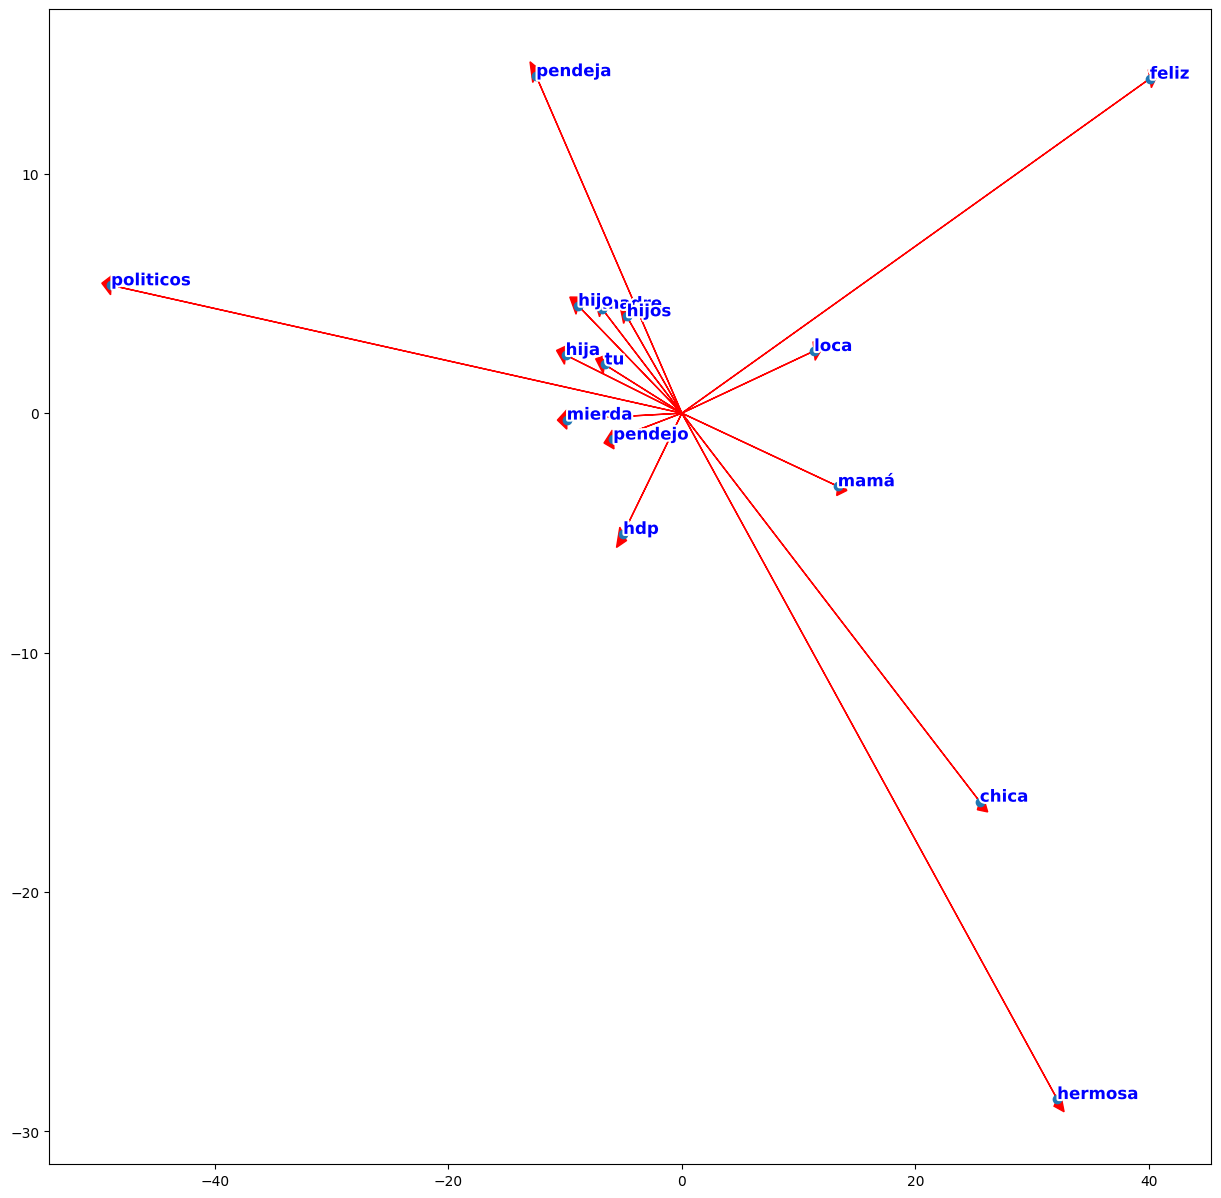

In [30]:
subsetword = ['politicos', 'corrupción', 'PRI', 'feliz', 
              'hermosa', 'chica', 'tu', 'hdp','madre','madres',
              '@usuario' ,'hijos', 'pendeja', 'pendejo','mierda', 
              'loca', 'hijo', 'hija', 'mamá', 'tía','padre','papá']

# t_words Las 1,000 mejores palabras según chi2 ( Algoritmo de selección de características)
# reduce_matriz Aquí estan las 1,000 mejores palabras en dos dimensiones

subreduce_matriz = []
ploted_subsetwords = []


for idx, word in enumerate(t_words):
    if word in subsetword:
        subreduce_matriz.append(reduce_matrix[idx])
        ploted_subsetwords.append(word)
    print_bar(idx, len(t_words), contexto="PROGRESO")

print()
Logger.debug(f"Palabras a graficar: {ploted_subsetwords}")
Logger.debug(f"Coordenadas: {subreduce_matriz}")

# Convertir a numpy array
subreduce_matriz = np.array(subreduce_matriz)


# Hacemos la gráfica de flechas
fig , ax = plt.subplots(figsize=(15, 15))

for word in subreduce_matriz:
    ax.arrow(0, 0, word[0], word[1], head_width=0.8, head_length=0.8, fc='red', ec='red', width=0.1e-2)
    ax.annotate(
        ploted_subsetwords[subreduce_matriz.tolist().index(word.tolist())], 
        (word[0], word[1]), 
        fontsize=12, 
        color='blue', 
        fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
    )

ax.scatter(subreduce_matriz[:,0], subreduce_matriz[:,1])

In [31]:
from wordcloud import WordCloud

In [32]:
texto = """


WikipediaLa enciclopedia libre
Buscar en Wikipedia

Buscar
Donar
Crear una cuenta
Acceso

Contenido esconder
(Arriba)
Campus
Programas académicos
Véase también
Referencias
Referencias externas
Universidad Iberoamericana León

Artículo
Hablar
Leer
Editar
Ver historial

Herramientas
Apariencia esconder
Texto

Pequeño

Estándar

Grande
Ancho

Estándar

Ancho
Color (beta)

Automático

Luz

Oscuro
Coordenadas : 21°07′43″N 101°37′34″O
De Wikipedia, la enciclopedia libre

Este artículo necesita citas adicionales para su verificación . Por favor, ayude a mejorar este artículo añadiendo citas de fuentes confiables . El material sin fuentes puede ser cuestionado y eliminado.
Buscar fuentes:  «Universidad Iberoamericana León»  –  noticias  · periódicos  · libros  · académico  · JSTOR ( mayo de 2018 ) ( Aprenda cómo y cuándo eliminar este mensaje ).
Universidad Iberoamericana León

Lema	La Verdad nos hará Libres (Español)
Lema en inglés	La verdad nos hará libres
Tipo	Institución de educación superior mixta, privada , católica romana, de investigación, sin fines de lucro
Establecido	1978 ; hace 47 años
Afiliación religiosa	Católico romano ( jesuita )
Afiliación académica	SUJ AUSJAL
Rector	P. Luis Alfonso González Valencia, SJ [ 1 ]
Estudiantes	3250
Ubicación	1640 Jorge Vértiz Campero SJ León,Guanajuato,México
Campus	34 acres
Bandera	Rojo  y Blanco
Sitio web	www.leon.uia.mx​​​
Mapa
Wikimedia | © OpenStreetMap
La Universidad Iberoamericana León (IBERO León) es una universidad privada, católica y jesuita ubicada en León , Guanajuato , México . Fue fundada en 1978 como campus de la Universidad Iberoamericana para extender su alcance al estado de Guanajuato y la región del Bajío . Actualmente, se gestiona de forma independiente desde el campus de la Ciudad de México y forma parte del Sistema Universitario Jesuita , la red universitaria más grande del mundo, con más de 200 universidades en los cinco continentes. [ 2 ]

La Universidad Iberoamericana León es una entidad privada, dependiente de Fomento a la Cultura y la Educación Superior del Bajío, A.C., que imparte docencia en todos los niveles educativos, tanto de licenciatura como de posgrado, fomenta las actividades culturales y científicas, [ 3 ] promueve la investigación científica y la producción cultural y literaria, [ 4 ] y realiza actividades complementarias. [ 5 ]

Campus
34 hectáreas de campus con 17.859 m 2 de superficie construida, 94 aulas, 33 laboratorios y 8 talleres, además de instalaciones deportivas y parque tecnológico. [ 6 ]

Programas académicos

Esta sección no cita ninguna fuente . Por favor, ayude a mejorar esta sección añadiendo citas de fuentes fiables . El material sin fuentes puede ser cuestionado y eliminado . ( Septiembre de 2018 ) ( Aprenda cómo y cuándo eliminar este mensaje )
Departamento de Arte y Diseño
Arquitectura
Diseño de producto
Diseño digital interactivo
Diseño y Artes Visuales
Arquitectura del paisaje
Interior arquitectónico
Diseño fotográfico
Diseño, Análisis y Creación de Posts
Departamento de Ciencias Básicas
Nutrición y Ciencia de los Alimentos
Ingeniería de Bionanotecnología
Departamento de Derecho
Licenciatura en Derecho
Relaciones internacionales
Maestría en Derecho Constitucional y Amparo (con el Instituto de Investigaciones Jurídicas de la UNAM)
Departamento de Ciencias Sociales y Humanidades
Comunicación
Psicología
Psicoterapia clínica
Departamento de Ciencias Económicas y Administrativas
Gestión y emprendimiento
Comercio Exterior y Logística Internacional
Estrategias contables y financieras
Desarrollo Turístico y Hotelero
Marketing y Publicidad, Desarrollo Organizacional e Innovación, Gestión Organizacional, Marketing Estratégico, Logística Internacional y Cadena de Suministro, Gestión de la Innovación Tecnológica
Departamento de educación
Análisis y Desarrollo de la Educación, Diseño Virtual, Maestría en Proyectos Educativos, Ed.D. [ aclaración necesaria ]
Departamento de ingeniería
Ingeniería biomédica, Ingeniería civil, Ingeniería industrial, Ingeniería mecánica y eléctrica, Ingeniería mecatrónica, Micro y nanoingeniería en electrónica, Ingeniería empresarial y de sistemas, Ingeniería de procesos logísticos.
Escuela de posgrado
Maestría: Derecho Constitucional, Diseño de Proyectos Educativos Virtuales, Política y Gestión Pública, Ciencias Ambientales con Énfasis en Sustentabilidad, Nutrición Clínica, Psicoterapia Clínica, Logística Internacional y Cadena de Suministro, Mercadeo Estratégico, Gestión de la Innovación Tecnológica, Alta Administración, Administración Organizacional, Diseño Fotográfico, Arquitectura de Interiores,
Doctorados: Ciencias Sociales, Complejidad e Interdisciplinariedad Doctorado en Ciencias Sociales, Complejidad e Interdisciplinareidad ; Administración; Educación.
Véase también
Lista de sitios jesuitas
Referencias
«El Mtro. Luis Alfonso González Valencia SJ Es nombrado Rector interino de la Ibero» .
«Universidad Iberoamericana León – Free-Apply.com» . aplicación gratuita.com . Consultado el 5 de julio de 2023 .
«Universidad Iberoamericana León, tendrá Semana Cultural Laboral 2017» (en español) . Consultado el 7 de octubre de 2017 .
«Colabora IECA con Universidad Iberoamericana» . Periódico Correo (en español europeo). 29 de abril de 2016 . Consultado el 7 de octubre de 2017 .
 Compromiso entre Estados Unidos y México en materia de educación superior: actividades actuales
"UIAC / Landa Arquitectos" . ArchDaily . 1 de enero de 2013. Consultado el 7 de octubre de 2017 .
Referencias externas
Sistema Universitario Jesuita Archivado el 10 de diciembre de 2020 en Wayback Machine.
Asociación Nacional de Universidades e Instituciones de Enseñanza Superior: ANUIES
Federación de Instituciones Mexicanas Particulares de Educación Superior, AC
Asociación de Colegios y Universidades Jesuitas en Norte América

Bases de datos de control de autoridad Editar esto en Wikidata
Internacional	
ISNIVIAF
Nacional	
Estados Unidos
Otro	
Yale LUX
Categorías :Universidad IberoamericanaEdificios y estructuras en León, GuanajuatoUniversidades y colegios jesuitas en MéxicoUniversidades y colegios establecidos en 19781978 establecimientos en MéxicoReligión en Guanajuato
Esta página se editó por última vez el 8 de septiembre de 2025 a las 14:40  (UTC) .
El texto está disponible bajo la Licencia Creative Commons Atribución-CompartirIgual 4.0 ; pueden aplicarse términos adicionales. Al usar este sitio, acepta las Condiciones de Uso y la Política de Privacidad . Wikipedia® es una marca registrada de Wikimedia Foundation, Inc. , una organización sin fines de lucro.
Política de privacidadAcerca de WikipediaDescargo de responsabilidadContactar con WikipediaCódigo de conductaDesarrolladoresEstadísticaDeclaración de cookiesVista móvil
Fundación Wikimedia
Desarrollado por MediaWiki


"""

[DEBUG] Tamaño de 1074 | Tokens: ['wikipediala', 'enciclopedia', 'libre', 'buscar', 'en', 'wikipedia', 'buscar', 'donar', 'crear', 'una', 'cuenta', 'acceso', 'contenido', 'esconder', '(', 'arriba', ')', 'campus', 'programas', 'académicos', 'véase', 'también', 'referencias', 'referencias', 'externas', 'universidad', 'iberoamericana', 'león', 'artículo', 'hablar', 'leer', 'editar', 'ver', 'historial', 'herramientas', 'apariencia', 'esconder', 'texto', 'pequeño', 'estándar', 'grande', 'ancho', 'estándar', 'ancho', 'color', '(', 'beta', ')', 'automático', 'luz', 'oscuro', 'coordenadas', ':', '21', '°', '07', '′', '43', '″', 'n', '101', '°', '37', '′', '34', '″', 'o', 'de', 'wikipedia', ',', 'la', 'enciclopedia', 'libre', 'este', 'artículo', 'necesita', 'citas', 'adicionales', 'para', 'su', 'verificación', '.', 'por', 'favor', ',', 'ayude', 'a', 'mejorar', 'este', 'artículo', 'añadiendo', 'citas', 'de', 'fuentes', 'confiables', '.', 'el', 'material', 'sin', 'fuentes', 'puede', 'ser', 'cuest

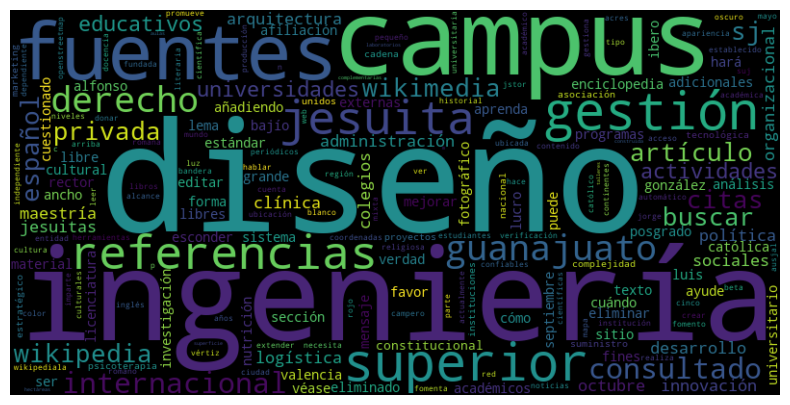

In [33]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

# Texto de ejemplo


# Tokenización
tokens = tokenizer.tokenize(texto.lower())
Logger.debug(f"Tamaño de {len(tokens)} | Tokens: {tokens}")


# Filtrar tokens para eliminar puntuación y caracteres no alfabéticos
cleaned_tokens = [token for token in tokens if re.match(r'^[a-záéíóúüñ]+$', token)]
Logger.debug(f"Tamaño de {len(cleaned_tokens)} | Cleaned Tokens: {cleaned_tokens}")


# Quitar stopwords
stop_words = stopwords.words('spanish') + ['universidad', 'iberoamericana', 'león','méxico','ciencias','educación','departamento']
cleaned_tokens = [token for token in cleaned_tokens if token not in stop_words]
Logger.debug(f"Tamaño de {len(cleaned_tokens)} | Limpio y sin stopwords: {cleaned_tokens}")


# Distribución de frecuencias
distribucion_frecuencias_ibero = nltk.FreqDist(cleaned_tokens)
Logger.debug(f"Frecuencia de palabras: {distribucion_frecuencias_ibero.most_common(20)}")


# Generar y mostrar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(distribucion_frecuencias_ibero)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()




# AHORA LO HACEMOS CON TWEETS  CON FEATURE SELECTION

[DEBUG]  Puntajes Chi2 de las mejores palabras: [  3.88391302  13.8004089    2.94580155  12.75322961  46.77952725
   2.56301765  59.2469122  138.32941578   4.39519919  31.16513
   2.66748382  24.00223476  33.23692121  15.68528246   2.26619156
  36.89974641  12.94850591  62.55989316  11.30388828 171.39595343
   7.65508256  33.5026597   12.54041039 179.859082   106.404039
   2.6754506    5.00491413   4.07948961  16.80930549  29.20523722
   3.96828498  12.2452227   14.4983931   36.6673755    3.77640427
  13.96444233  16.16114763  56.7995841   12.35734143   3.85458481
  11.63277971 117.74826774   3.64399071 215.96459656  21.79650752
   2.37386491   3.55248136  40.27135417  24.70732766  17.64091506
  46.40316741  28.57898617  12.19662671  12.50198692   5.33435576
   3.32203265  15.7145895    9.89299463  37.87238396  16.79305611
   2.06274833   5.97806434   2.1366729   24.93051593  97.44410479
   9.7407768   24.47530944   4.7115954   23.28690712   3.57277416
  27.58840289  21.08888369 289.81

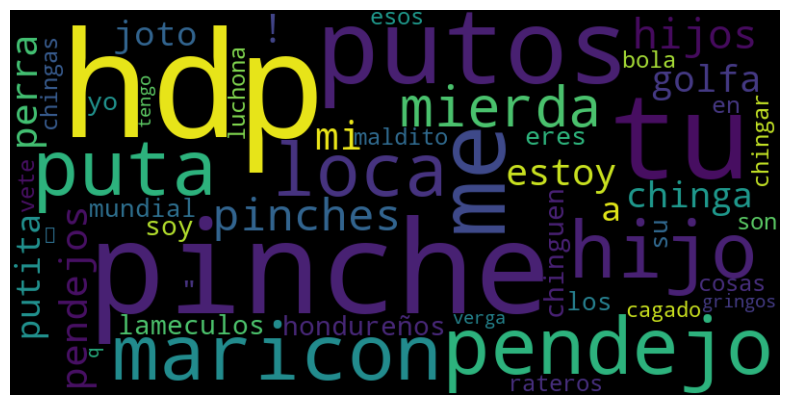

In [34]:

# Chi2
feature_selector = SelectKBest(chi2, k=1000)
feature_selector.fit(bolsa_de_palabras_tr, tr_y) # EL tr_y son las etiquetas agresivo o no agresivo


# Extraer las palabras seleccionadas
palabras_mejores_indices = feature_selector.get_support(indices=True)
palabras = [dict_indices_invertido[indice] for indice in palabras_mejores_indices]


# Extraer los scores
chi2_scores = feature_selector.scores_
best_scores = chi2_scores[palabras_mejores_indices]
Logger.debug(f" Puntajes Chi2 de las mejores palabras: {best_scores}")


# Distribución de frecuencias
distribucion_frecuencias_tweets = {palabra: score for palabra, score in zip(palabras, best_scores)}
mejores_50 = dict(sorted(distribucion_frecuencias_tweets.items(), key=lambda item: item[1], reverse=True)[:50])
Logger.debug(f"Frecuencia de palabras en tweets: {mejores_50}")

# Generar y mostrar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(mejores_50)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
